<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Principal Component Analysis (PCA)

---

## Learning Objectives


### Core

- Understand the purpose of dimensionality reduction
- Describe what PCA does and what it is used for in data science
- Understand key terms: 
 - eigenvalues 
 - eigenvectors 
 - explained variance
 - principal components

### Target

- Practice computing PCA with sklearn
- Interpret PCA results graphically
- Produce a scree plot

### Stretch

- Repeat the derivation of PCA by hand
- Practice computing PCA manually

---

### Lesson Guide
- [What is PCA?](#whatispca)
    - [Eigenvalues and Eigenvectors](#eigenpairs)
    - [Principal Components](#pcs)
- [Manual PCA Codealong](#manual-codealong)
    - [1. Basic EDA](#basic-eda)
    - [2. Subset and Normalize](#subset)
    - [3. Find the Covariance Matrix](#corr)
    - [4. Eigenvalues and Eigenvectors](#eigen)
    - [5. Explained Variance](#var)
    - [6. Projection Matrix V](#projection)
    - [7. Transformed Matrix Z](#transformed)
    - [8-12. Plot and Interpret Principal Components](#plot-components)
- [PCA with sklearn](#sklearn)
- [Conclusions](#conclusions)
- [Additional Resources](#more-reading)

<a id="whatispca"></a>
## What is PCA?

---

PCA is the quintessential "dimensionality reduction" algorithm. 

_Dimensionality reduction_ is the process of combining or collapsing the existing features (columns in X) into fewer features. 

These hopefully:

- Retain the signal in the original data, and
- Reduce noise.

---

PCA finds the linear combinations of your current predictor variables that create new "principal components". The principal components explain (in order) the maximum possible amount of variance in your predictors.

A more natural way of thinking about PCA is that **it transforms the coordinate system so that the axes become the  most concise, informative descriptors of our data as a whole.**

The old axes are the original variables (columns). The new axes are the principal components from PCA.


### The Process of PCA 

---

Say we have a matrix $X$ of predictor variables. PCA will give us the ability to transform our $X$ matrix into a new matrix $Z$. 

First we will derive a **weighting matrix** $V$ from the correlational/covariance structure of $X$ that allows us to perform the transformation.

$$Z = X V$$

Each successive dimension (column) in $Z$ will be rank-ordered according to variance in its values!

**Two assumptions that PCA makes:**
1. **Linearity:** The data does not hold nonlinear relationships.
2. **Large variances define importance:** The dimensions are constructed to maximize remaining variance.

The resulting principal components (columns of $Z$) will be uncorrelated. This makes PCA a useful preprocessing step for algorithms requiring uncorrelated input features.

### Eigenvalues and Eigenvectors

---


![orthogonal eigenvectors](./images/eigenvectors_orthogonal.png) 

![transformed XY](./images/transformed_xy.png) 

<a id="eigenpairs"></a>
**EIGENVECTORS**

An eigenvector specifies a direction through the original coordinate space. The eigenvector with the highest corresponding eigenvalue is the first principal component.

---

**EIGENVALUES**

Eigenvalues indicate the amount of variance in the direction of its corresponding eigenvector.

---

![eigenvalue](./images/eigenvalue.png)

**Every eigenvector has a corresponding eigenvalue!** These are sometimes called **eigenpairs**.

![PCA coord transform](./images/pca_coordinate_transformation.png) 

<a id="pcs"></a>
### Principal Components

---

What is a principal component? **Principal components are the vectors that define the new coordinate system for your data.** Transforming your original data columns onto the principal component axes construct new variables that are optimized to explain as much variance as possible and to be independent (**uncorrelated**).

Creating these variables is a well-defined mathematical process. In essence, **each component is created as a weighted sum of your original columns, such that all components are orthogonal (perpendicular) to each other**.

**PRINCIPAL COMPONENT TRANSFORMATION OF DATA: PC2 VS PC1**

[setosa.io has an extremely nice interactive visualization for PCA](http://setosa.io/ev/principal-component-analysis/)

---

![setosa pc1](./images/setosa_pc1.png) 

### Why would we want to do PCA?

---

- We can reduce the number of dimensions (remove less important components), while losing mostly noise rather than signal.
- Since we are assuming our variables are interrelated (at least in the sense that they together explain a dependent variable), the information of interest should exist along directions with largest variance.
- The directions of largest variance should have the highest signal-to-noise ratio.
- Correlated predictor variables (also referred to as "redundancy" of information) are combined into independent variables. Our predictors from PCA are guaranteed to be independent.

---

[Good paper on PCA](http://arxiv.org/pdf/1404.1100.pdf)

[Nice site on performing PCA](http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html#pca-vs-lda)

<a id="manual-codealong"></a>
## Manual PCA Codealong

---

**MANUAL PCA STEPS**

1. **Standardize data.** Centering is required!!! Full normalization is nice for visuals later.
2. **Calculate eigenvectors and eigenvalues** of the correlation or covariance matrix.
3. **Sort eigenvalues.** Choose eigenvectors that correspond to the largest eigenvalues. The number you choose is up to you, but we will take 2 for the sake of visualization here.
4. **Construct the projection weighting matrix $V$** from the eigenvectors.
5. **Transform the original dataset $X$ with $V$.** Obtains the new 2-dimensional transformed matrix $Z$.

---

**DATA**

We are going to be using a simple 75-row, 4-column dataset with demographic information. It contains:

    age (limited to 20-65)
    income
    health (a rating on a scale of 1-100, where 100 is the best health)
    stress (a rating on a scale of 1-100, where 100 is the most stressed)
    
All of the variables are continuous.

---

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
sns.set(font_scale=1.5)
np.set_printoptions(precision=4)

warnings.simplefilter('ignore')

In [2]:
demo = pd.read_csv('../../../../resource-datasets/simple_demographics/simple_demographics.csv')
demo.head()

,age,health,income,stress
0,21,74.0,42746.0,53.0
1,33,64.0,72792.0,49.0
2,30,78.0,74178.0,64.0
3,32,71.0,102548.0,63.0
4,57,46.0,120418.0,35.0


<a id="basic-eda"></a>
### 1. Basic EDA

Make a seaborn regplot for each of:

1. age vs. income
2. age vs. health
3. age vs. stress

Also make a pairplot of the entire dataset.

---

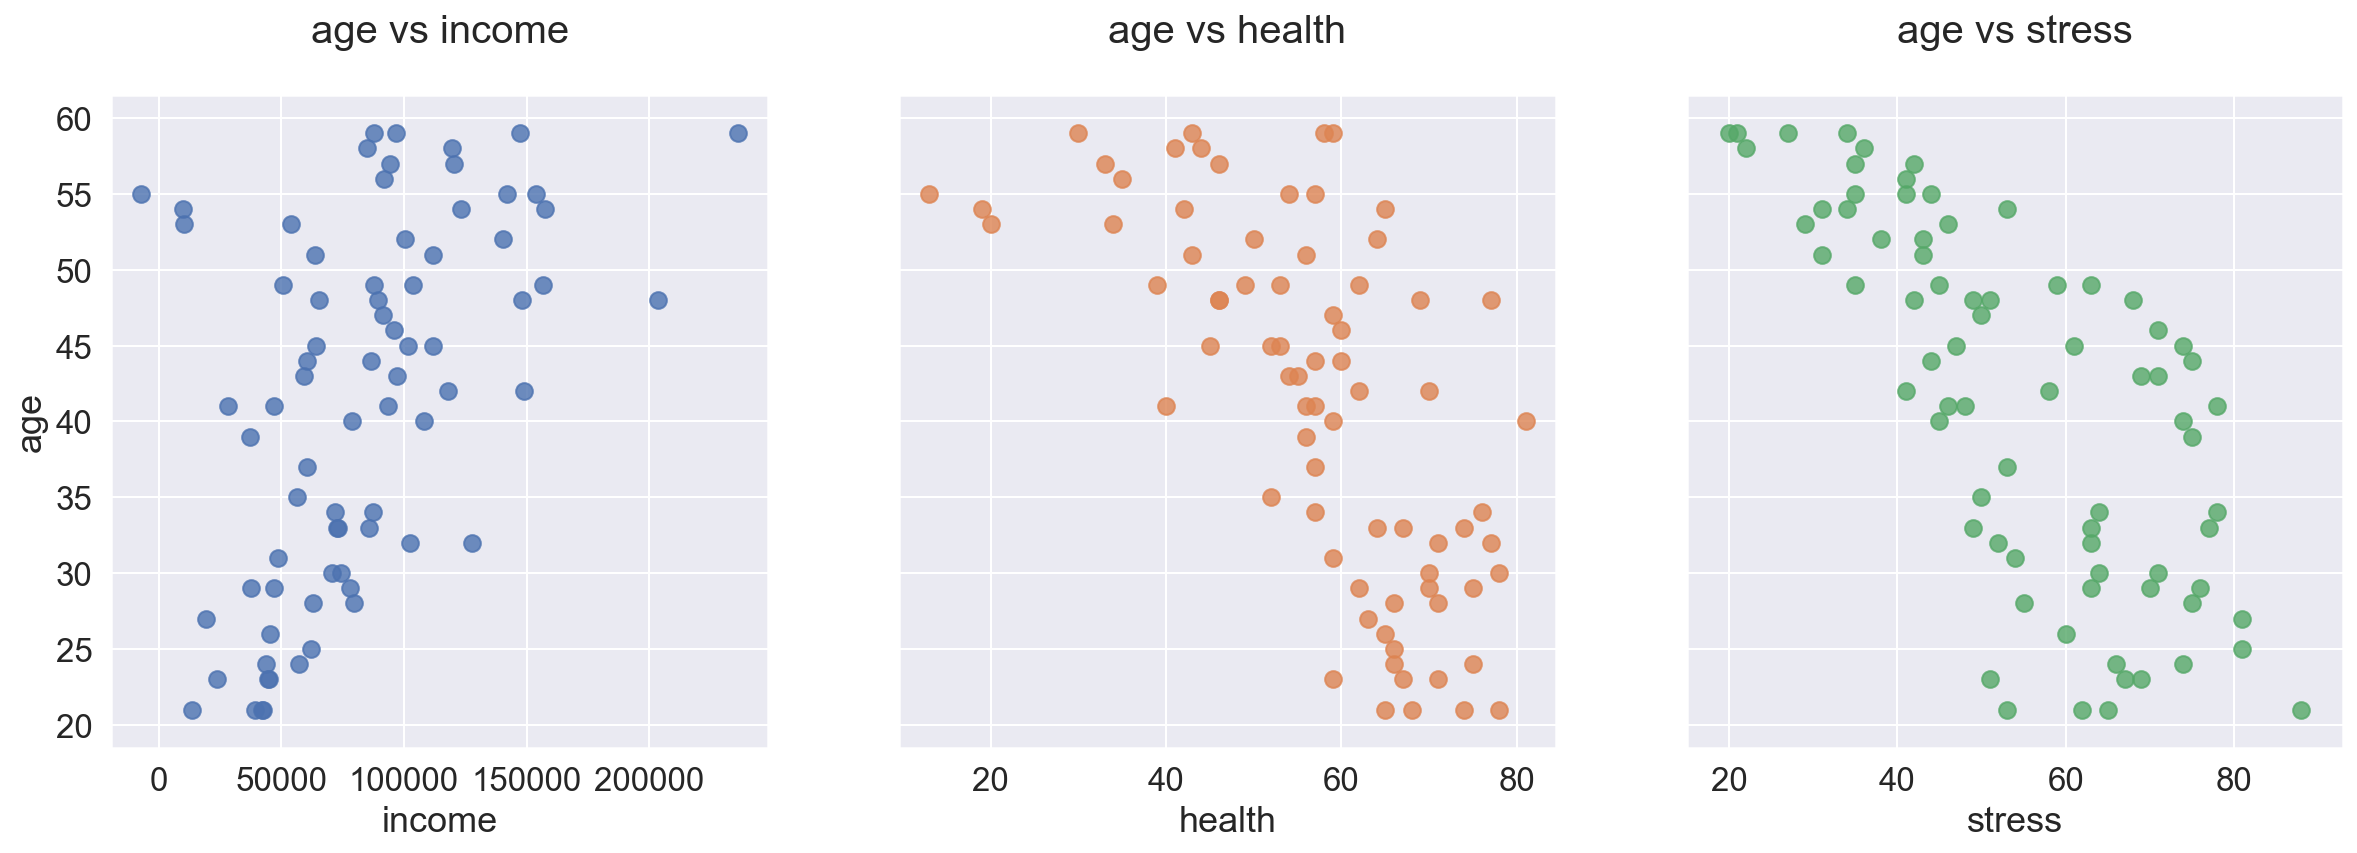

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6), sharey=True)

axes[0] = sns.regplot('income', 'age', data=demo, fit_reg=False, scatter_kws={
                      's': 70}, label='age vs income', ax=axes[0])
axes[0].set_title('age vs income\n', fontsize=20)

axes[1] = sns.regplot('health', 'age', data=demo, fit_reg=False, scatter_kws={
                      's': 70}, label='age vs health', ax=axes[1])
axes[1].set_title('age vs health\n', fontsize=20)
axes[1].set_ylabel('')

axes[2] = sns.regplot('stress', 'age', data=demo,
                      fit_reg=False, scatter_kws={'s': 70}, ax=axes[2])
axes[2].set_title('age vs stress\n', fontsize=20)
axes[2].set_xlim(demo.stress.min() - 5, demo.stress.max() + 5)
axes[2].set_ylabel('')

plt.show()

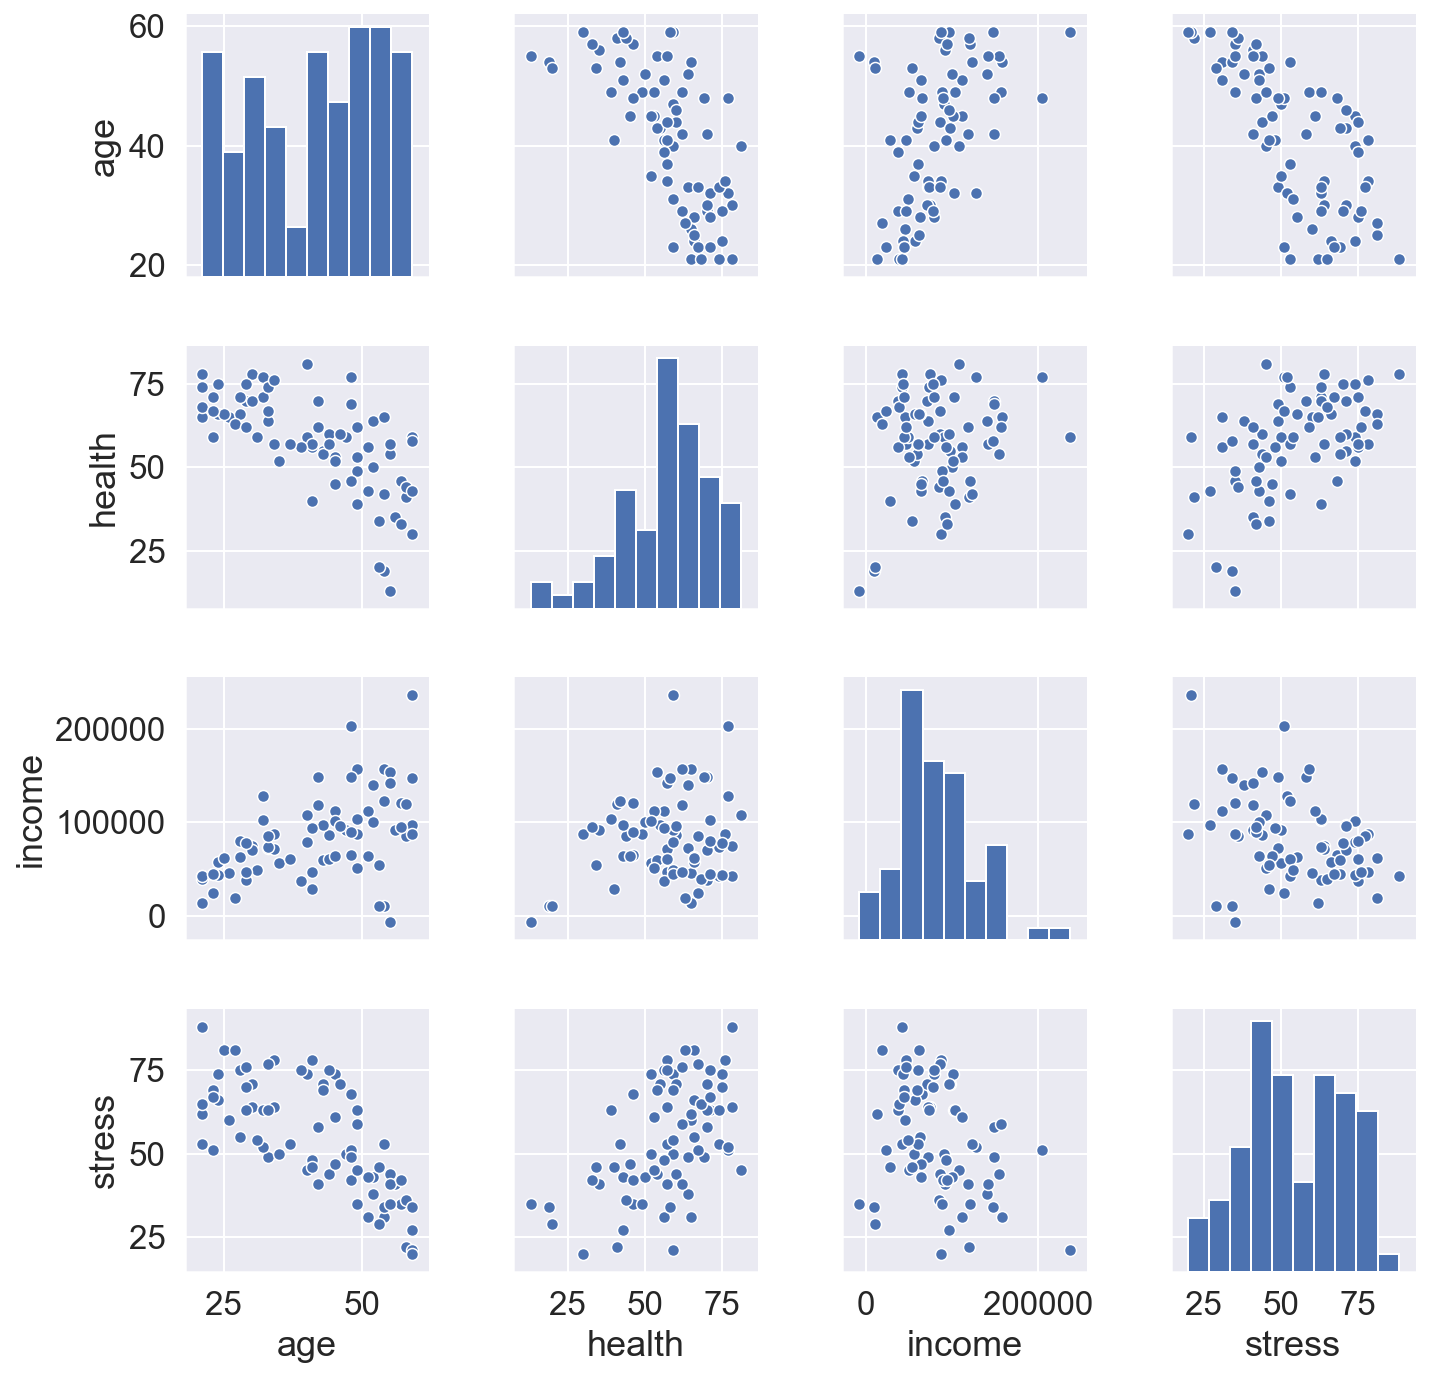

In [4]:
sns.pairplot(demo)
plt.show()

<a id="subset"></a>
### 2. Subset and normalize

Subset the data to only include:

    income
    health
    stress

We will use `age` as the target variable.

---

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

columns = ['health', 'income', 'stress']
demo_noage = demo[columns]

demo_noage = scaler.fit_transform(demo_noage)
demo_noage = pd.DataFrame(demo_noage, columns=columns)

demo_noage.head()

,health,income,stress
0,1.170996,-0.900920,-0.084764
1,0.476180,-0.220986,-0.329274
2,1.448922,-0.189621,0.587640
3,0.962551,0.452385,0.526513
4,-0.774488,0.856779,-1.185061


In [6]:
demo_noage.describe()

,health,income,stress
count,7.500000e+01,7.500000e+01,7.500000e+01
mean,-1.495100e-16,-1.021405e-16,2.072416e-16
std,1.006734e+00,1.006734e+00,1.006734e+00
min,-3.067380e+00,-2.028358e+00,-2.101976e+00
25%,-5.313024e-01,-7.437904e-01,-7.266039e-01
50%,1.287725e-01,-7.970866e-02,-8.476366e-02
75%,6.846250e-01,4.674337e-01,8.627147e-01
max,1.657367e+00,3.477803e+00,2.054704e+00


<a id="corr"></a>
### 3. Calculate the covariance matrix

We will have to calculate the eigenvectors and eigenvalues of the covariance matrix.

---

In [7]:
demo_noage_cov = demo_noage.cov()
demo_noage_cov

,health,income,stress
health,1.013514,0.194632,0.534794
income,0.194632,1.013514,-0.352626
stress,0.534794,-0.352626,1.013514


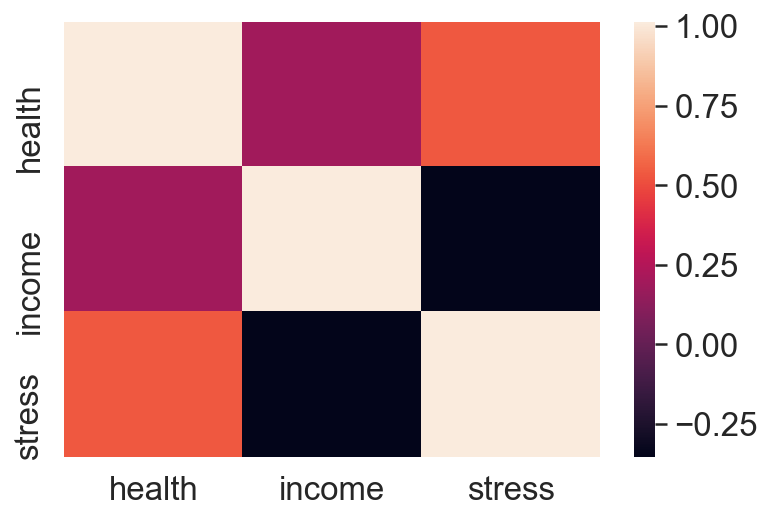

In [8]:
sns.heatmap(demo_noage.cov())
plt.ylim([demo_noage.shape[1], 0])
plt.show()

<a id="eigen"></a>
### 4. Calculate the eigenvalues and eigenvectors of the covariance matrix

Numpy has a convenient function to calculate this:

    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    
---

In [9]:
eigen_values, eigen_vectors = np.linalg.eig(demo_noage_cov)

print("Eigenvalues:")
print(eigen_values)
print("Eigenvectors:")
print(eigen_vectors)

Eigenvalues:
[0.2736 1.5775 1.1894]
Eigenvectors:
[[ 0.5953 -0.6188 -0.5126]
 [-0.4679  0.2517 -0.8472]
 [-0.6532 -0.7441  0.1397]]


<a id="var"></a>
### 5. Calculate and plot the explained variance

A useful measure is the **explained variance**, which is calculated from the eigenvalues. 

The explained variance tells us how much information (variance) is captured by each principal component.

$$ {\rm Explained\ Variance}_{i} = \bigg(\frac{{\rm eigenvalue}_i}{\sum_{j=1}^n{{\rm eigenvalue}_{j}}}\bigg) \cdot 100$$

---

In [10]:
tot = sum(eigen_values)
var_exp = [(i / tot) * 100 for i in sorted(eigen_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(var_exp)
print(cum_var_exp)

[51.88189227607146, 39.11912506942573, 8.998982654502798]
[ 51.8819  91.001  100.    ]


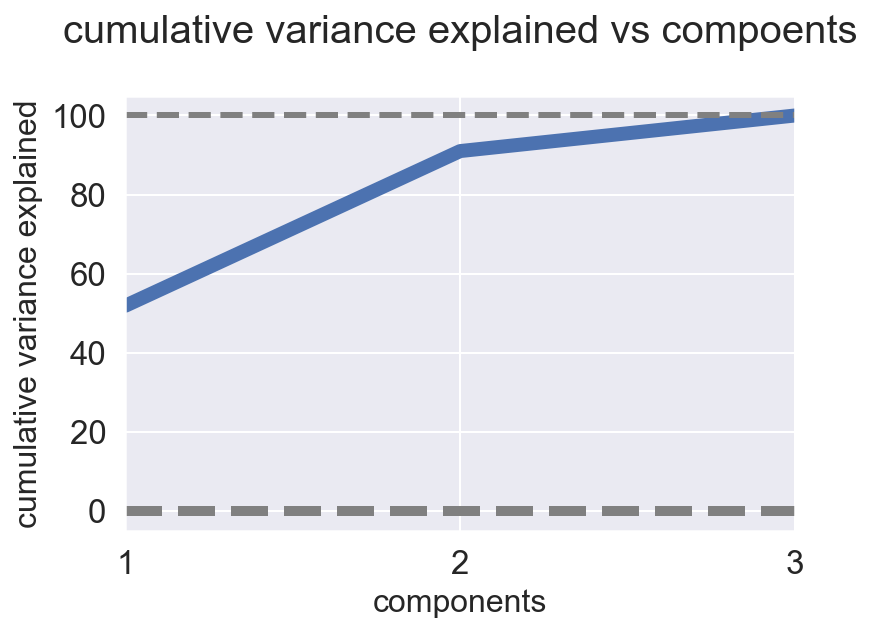

In [11]:
plt.figure(figsize=(6, 4))

component_number = [1, 2, 3]

plt.plot(component_number, cum_var_exp, lw=7)

plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
plt.axhline(y=100, linewidth=3, color='grey', ls='dashed')


ax = plt.gca()
ax.set_xlim([1, 3])
ax.set_ylim([-5, 105])

ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('components', fontsize=16)
ax.set_xticks(list(range(1, 4)))
ax.set_title('cumulative variance explained vs compoents\n', fontsize=20)

plt.show()

<a id="projection"></a>
### 6. Construct the Projection Matrix $V$

This is a matrix of our top eigenvectors.

The eigenvectors are concatenated as columns.

1. Start by ordering the eigenvectors by their corresponding eigenvalues largest to smallest.
1. Concatenate the eigenvectors together, for example with `np.hstack()`.
1. Construct the projection matrix.
1. Form the dot product of the data and the projection matrix.
---

In [12]:
# Sort the pairs of eigenvalues and eigenvectors according to eigenvalues

value_vector_pairs = [[round(eigen_values[i], 4), eigen_vectors[:, i]]
                      for i in range(len(eigen_values))]
value_vector_pairs.sort(reverse=True)

In [13]:
value_vector_pairs

[[1.5775, array([-0.6188,  0.2517, -0.7441])],
 [1.1894, array([-0.5126, -0.8472,  0.1397])],
 [0.2736, array([ 0.5953, -0.4679, -0.6532])]]

In [14]:
def projection_matrix(value_vector_pairs, d):
    ''' 
        Extract the eigenvectors and insert them as column vectors
        into a new matrix
    '''
    projection_matrix = np.hstack((value_vector_pairs[i][1].reshape(
        len(value_vector_pairs), 1)
        for i in range(d)))
    return projection_matrix

In [15]:
# Return the projection matrices
for i in range(3, 0, -1):
    print('Weight data {}d PCA projection matrix:'.format(i))
    print(projection_matrix(value_vector_pairs, i))
    print()

Weight data 3d PCA projection matrix:
[[-0.6188 -0.5126  0.5953]
 [ 0.2517 -0.8472 -0.4679]
 [-0.7441  0.1397 -0.6532]]

Weight data 2d PCA projection matrix:
[[-0.6188 -0.5126]
 [ 0.2517 -0.8472]
 [-0.7441  0.1397]]

Weight data 1d PCA projection matrix:
[[-0.6188]
 [ 0.2517]
 [-0.7441]]



<a id="transformed"></a>
### 7. Construct the Transformed 2D Matrix $Z$

To do this, we take the dot product of our 3D demographic matrix $X$ with the projection matrix $V$, i.e.

```python
X.dot(V)
```

In our case, $X$ is the matrix `demo_noage` and $V$ is the matrix of eigenvectors.

Then the we obtain the following for the matrix $Z$ depending on how many components we want to retain.

---

In [16]:
list(range(3, 0, -1))

[3, 2, 1]

In [17]:
for i in range(3, 0, -1):
    print('Projection on {} principal components:'.format(i))
    print(demo_noage.dot(projection_matrix(value_vector_pairs, i)).head())
    print()

Projection on 3 principal components:
          0         1         2
0 -0.888292  0.151081  1.173961
1 -0.105246 -0.102894  0.601947
2 -1.381570 -0.500060  0.567324
3 -0.873514 -0.803147  0.017339
4  1.576772 -0.494324 -0.087775

Projection on 2 principal components:
          0         1
0 -0.888292  0.151081
1 -0.105246 -0.102894
2 -1.381570 -0.500060
3 -0.873514 -0.803147
4  1.576772 -0.494324

Projection on 1 principal components:
          0
0 -0.888292
1 -0.105246
2 -1.381570
3 -0.873514
4  1.576772



#### The variance of the projected features corresponds to the eigenvalues:

In [18]:
for i in range(3, 0, -1):
    print('For {} principal components:'.format(i))
    print((demo_noage.dot(projection_matrix(value_vector_pairs, i)
                          )).var())
    print()

For 3 principal components:
0    1.577490
1    1.189433
2    0.273618
dtype: float64

For 2 principal components:
0    1.577490
1    1.189433
dtype: float64

For 1 principal components:
0    1.57749
dtype: float64



In [19]:
eigen_values

array([0.2736, 1.5775, 1.1894])

#### The covariance matrix of the original features is obtained by forming the matrix product

$$V\; S \; V^T$$

Here $V$ is the matrix of eigenvectors and $S$ is a diagonal matrix containing the eigenvalues of the covariance matrix on its diagonal.

In [20]:
V = eigen_vectors
S = np.diag(eigen_values)
print("The matrix of eigenvectors:")
print(V)
print()
print("The diagonal matrix of eigenvalues:")
print(S)
print()

cov_orig = V.dot(S.dot(V.T))

print("Covariance matrix constructed as V S VT")
print(cov_orig)
print()
print('This matrix is the same as the original covariance matrix:')
print(np.allclose(cov_orig, demo_noage.cov()))

The matrix of eigenvectors:
[[ 0.5953 -0.6188 -0.5126]
 [-0.4679  0.2517 -0.8472]
 [-0.6532 -0.7441  0.1397]]

The diagonal matrix of eigenvalues:
[[0.2736 0.     0.    ]
 [0.     1.5775 0.    ]
 [0.     0.     1.1894]]

Covariance matrix constructed as V S VT
[[ 1.0135  0.1946  0.5348]
 [ 0.1946  1.0135 -0.3526]
 [ 0.5348 -0.3526  1.0135]]

This matrix is the same as the original covariance matrix:
True


#### The covariance matrix of the new principal component features is obtained by forming the matrix product

$$V^T\; A\; V$$

Here $V$ is the matrix of eigenvectors and $A$ is the covariance matrix of the data.

The result is a diagonal matrix with the eigenvalues on the diagonal.

In [21]:
A = demo_noage.cov()
cov_new = V.T.dot(A.dot(V))
print(cov_new)
print()
print('This matrix is the same as the new covariance matrix:')
np.allclose(cov_new, S)

[[ 2.7362e-01 -1.8445e-16 -1.7663e-16]
 [-1.1721e-16  1.5775e+00 -5.0687e-16]
 [-1.4758e-16 -5.4941e-16  1.1894e+00]]

This matrix is the same as the new covariance matrix:


True

#### The transpose $V^T$ is the inverse matrix of $V$ (such matrices are called orthogonal).

In [22]:
print(V.T.dot(V))

[[ 1.0000e+00  2.9994e-16  1.9096e-17]
 [ 2.9994e-16  1.0000e+00 -6.2931e-16]
 [ 1.9096e-17 -6.2931e-16  1.0000e+00]]


In [23]:
print('V.T is the inverse of V:')
print(np.allclose(V.T.dot(V), np.eye(len(V))))

V.T is the inverse of V:
True


#### We want to use the first two principal components:

In [24]:
Z = demo_noage.dot(projection_matrix(value_vector_pairs, 2))

<a id="plot-components"></a>
### 8. Plot Principal Component 2 vs 1

PC1 is the first column in $Z$, and PC2 is the second.

Notice how they are uncorrelated.

---

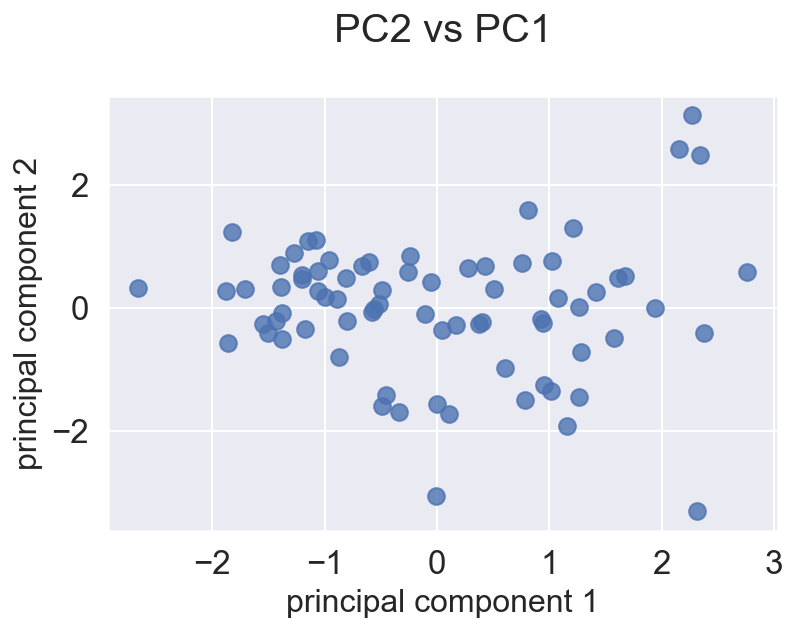

In [25]:
fig = plt.figure(figsize=(6, 4))

ax = fig.gca()
sns.regplot(Z.iloc[:, 0], Z.iloc[:, 1],
            fit_reg=False, scatter_kws={'s': 70}, ax=ax)

ax.set_xlabel('principal component 1', fontsize=16)
ax.set_ylabel('principal component 2', fontsize=16)

ax.set_title('PC2 vs PC1\n', fontsize=20)

plt.show()

#### The projected features are uncorrelated:

In [26]:
[np.allclose(
    demo_noage.dot(projection_matrix(value_vector_pairs, i)).corr(),
    np.eye(i)) for i in range(1, 4)]

[True, True, True]

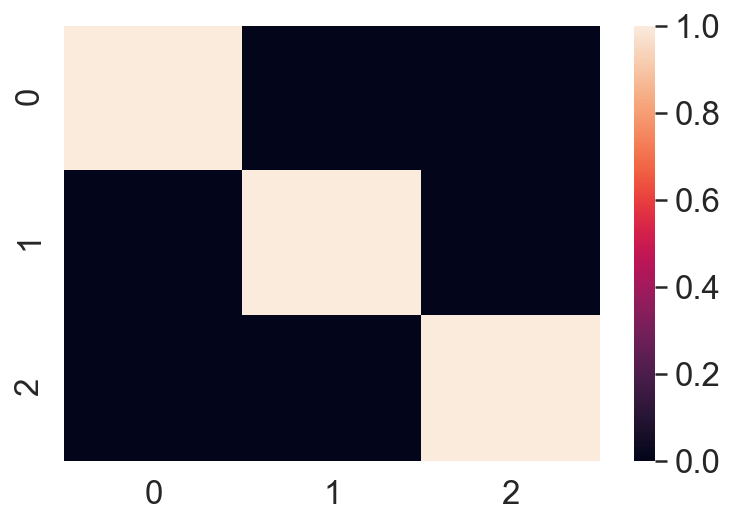

In [27]:
sns.heatmap(demo_noage.dot(projection_matrix(value_vector_pairs, 3)).corr())
plt.ylim([demo_noage.shape[1], 0])
plt.show()

#### The eigenvectors of the covariance matrix are pairwise orthogonal

In [28]:
# create all possible pairs between the given columns
from itertools import combinations
combs = list(combinations(list(range(len(V))), 2))
print(combs)

[(0, 1), (0, 2), (1, 2)]


In [29]:
# take the dot product of all possible pairs of eigenvectors
for comb in combs:
    print(np.allclose(np.dot(V[:, comb[0]], V[:, comb[1]]), 0))

True
True
True


### 9. Plot age vs principal component 1 with regplot

Look how tight the relationship is. PC1 took the shared variance out of income, health, and stress, which are intuitively directly related to increasing age. 

This principal component, or more specifically the column weighting matrix $V$, is essentially **capturing the latent age variance embedded in these variables.**

---

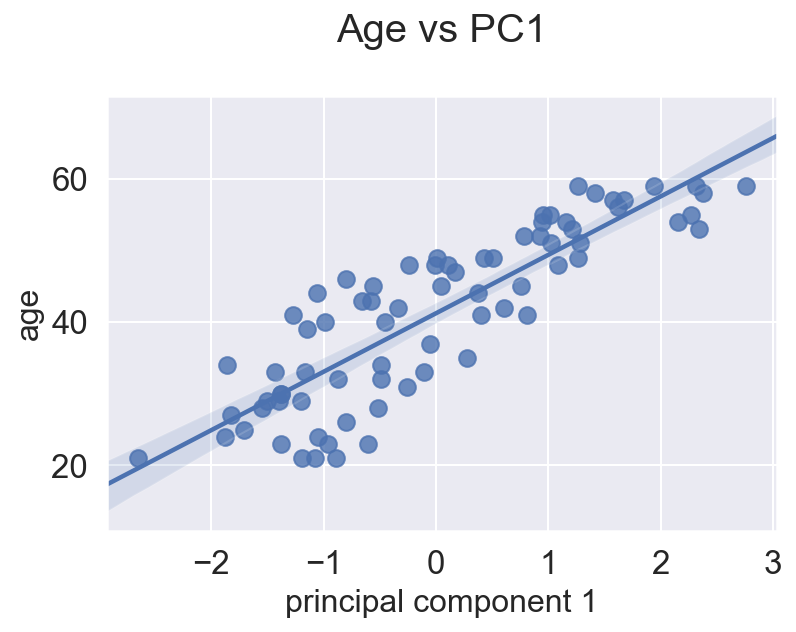

In [30]:
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()
sns.regplot(Z.iloc[:, 0], demo.age.values,
            fit_reg=True, scatter_kws={'s': 70}, ax=ax)

ax.set_xlabel('principal component 1', fontsize=16)
ax.set_ylabel('age', fontsize=16)

ax.set_title('Age vs PC1\n', fontsize=20)

plt.show()

### 10. Concatenate PC1 and PC2 to the full demographic (4D) dataset, then melt it with PC1 and PC2 and index variables

1. Renormalize so that all 4 variables are on the same scale.
2. Remember the pandas melt code:

```python
melted_df = pd.melt(df, id_vars=['PC1','PC2'])
```

---

In [31]:
demo_pcs = demo.copy()
columns_1 = ['age', 'health', 'income', 'stress']

demo_pcs = scaler.fit_transform(demo_pcs)
demo_pcs = pd.DataFrame(demo_pcs, columns=columns_1)

demo_pcs['PC1'] = Z.iloc[:, 0]
demo_pcs['PC2'] = Z.iloc[:, 1]

In [32]:
demo_pcs.head()

,age,health,income,stress,PC1,PC2
0,-1.713067,1.170996,-0.900920,-0.084764,-0.888292,0.151081
1,-0.697415,0.476180,-0.220986,-0.329274,-0.105246,-0.102894
2,-0.951328,1.448922,-0.189621,0.587640,-1.381570,-0.500060
3,-0.782052,0.962551,0.452385,0.526513,-0.873514,-0.803147
4,1.333890,-0.774488,0.856779,-1.185061,1.576772,-0.494324


In [33]:
demo_pcs.shape

(75, 6)

In [34]:
demo_pcs = pd.melt(demo_pcs, id_vars=['PC1', 'PC2'])

In [35]:
demo_pcs.shape

(300, 4)

In [36]:
demo_pcs.variable.unique()

array(['age', 'health', 'income', 'stress'], dtype=object)

In [37]:
demo_pcs.head(20)

,PC1,PC2,variable,value
0,-0.888292,0.151081,age,-1.713067
1,-0.105246,-0.102894,age,-0.697415
2,-1.381570,-0.500060,age,-0.951328
3,-0.873514,-0.803147,age,-0.782052
4,1.576772,-0.494324,age,1.333890
5,-1.199184,0.473110,age,-1.035966
6,0.373191,-0.269049,age,0.233600
7,0.780857,-1.494909,age,0.910702
8,0.169922,-0.271939,age,0.487513
9,-0.804870,0.481272,age,-1.289879


### 11. Use lmplot to check out PC1 vs all 4 variables

Make the `col` keyword argument "variable" and the `hue` keyword argument "variable" as well, assuming that's what you called them in the melt command (those are the defaults).

Make `col_wrap = 2` and `size = 7` or something to make it nice.

---

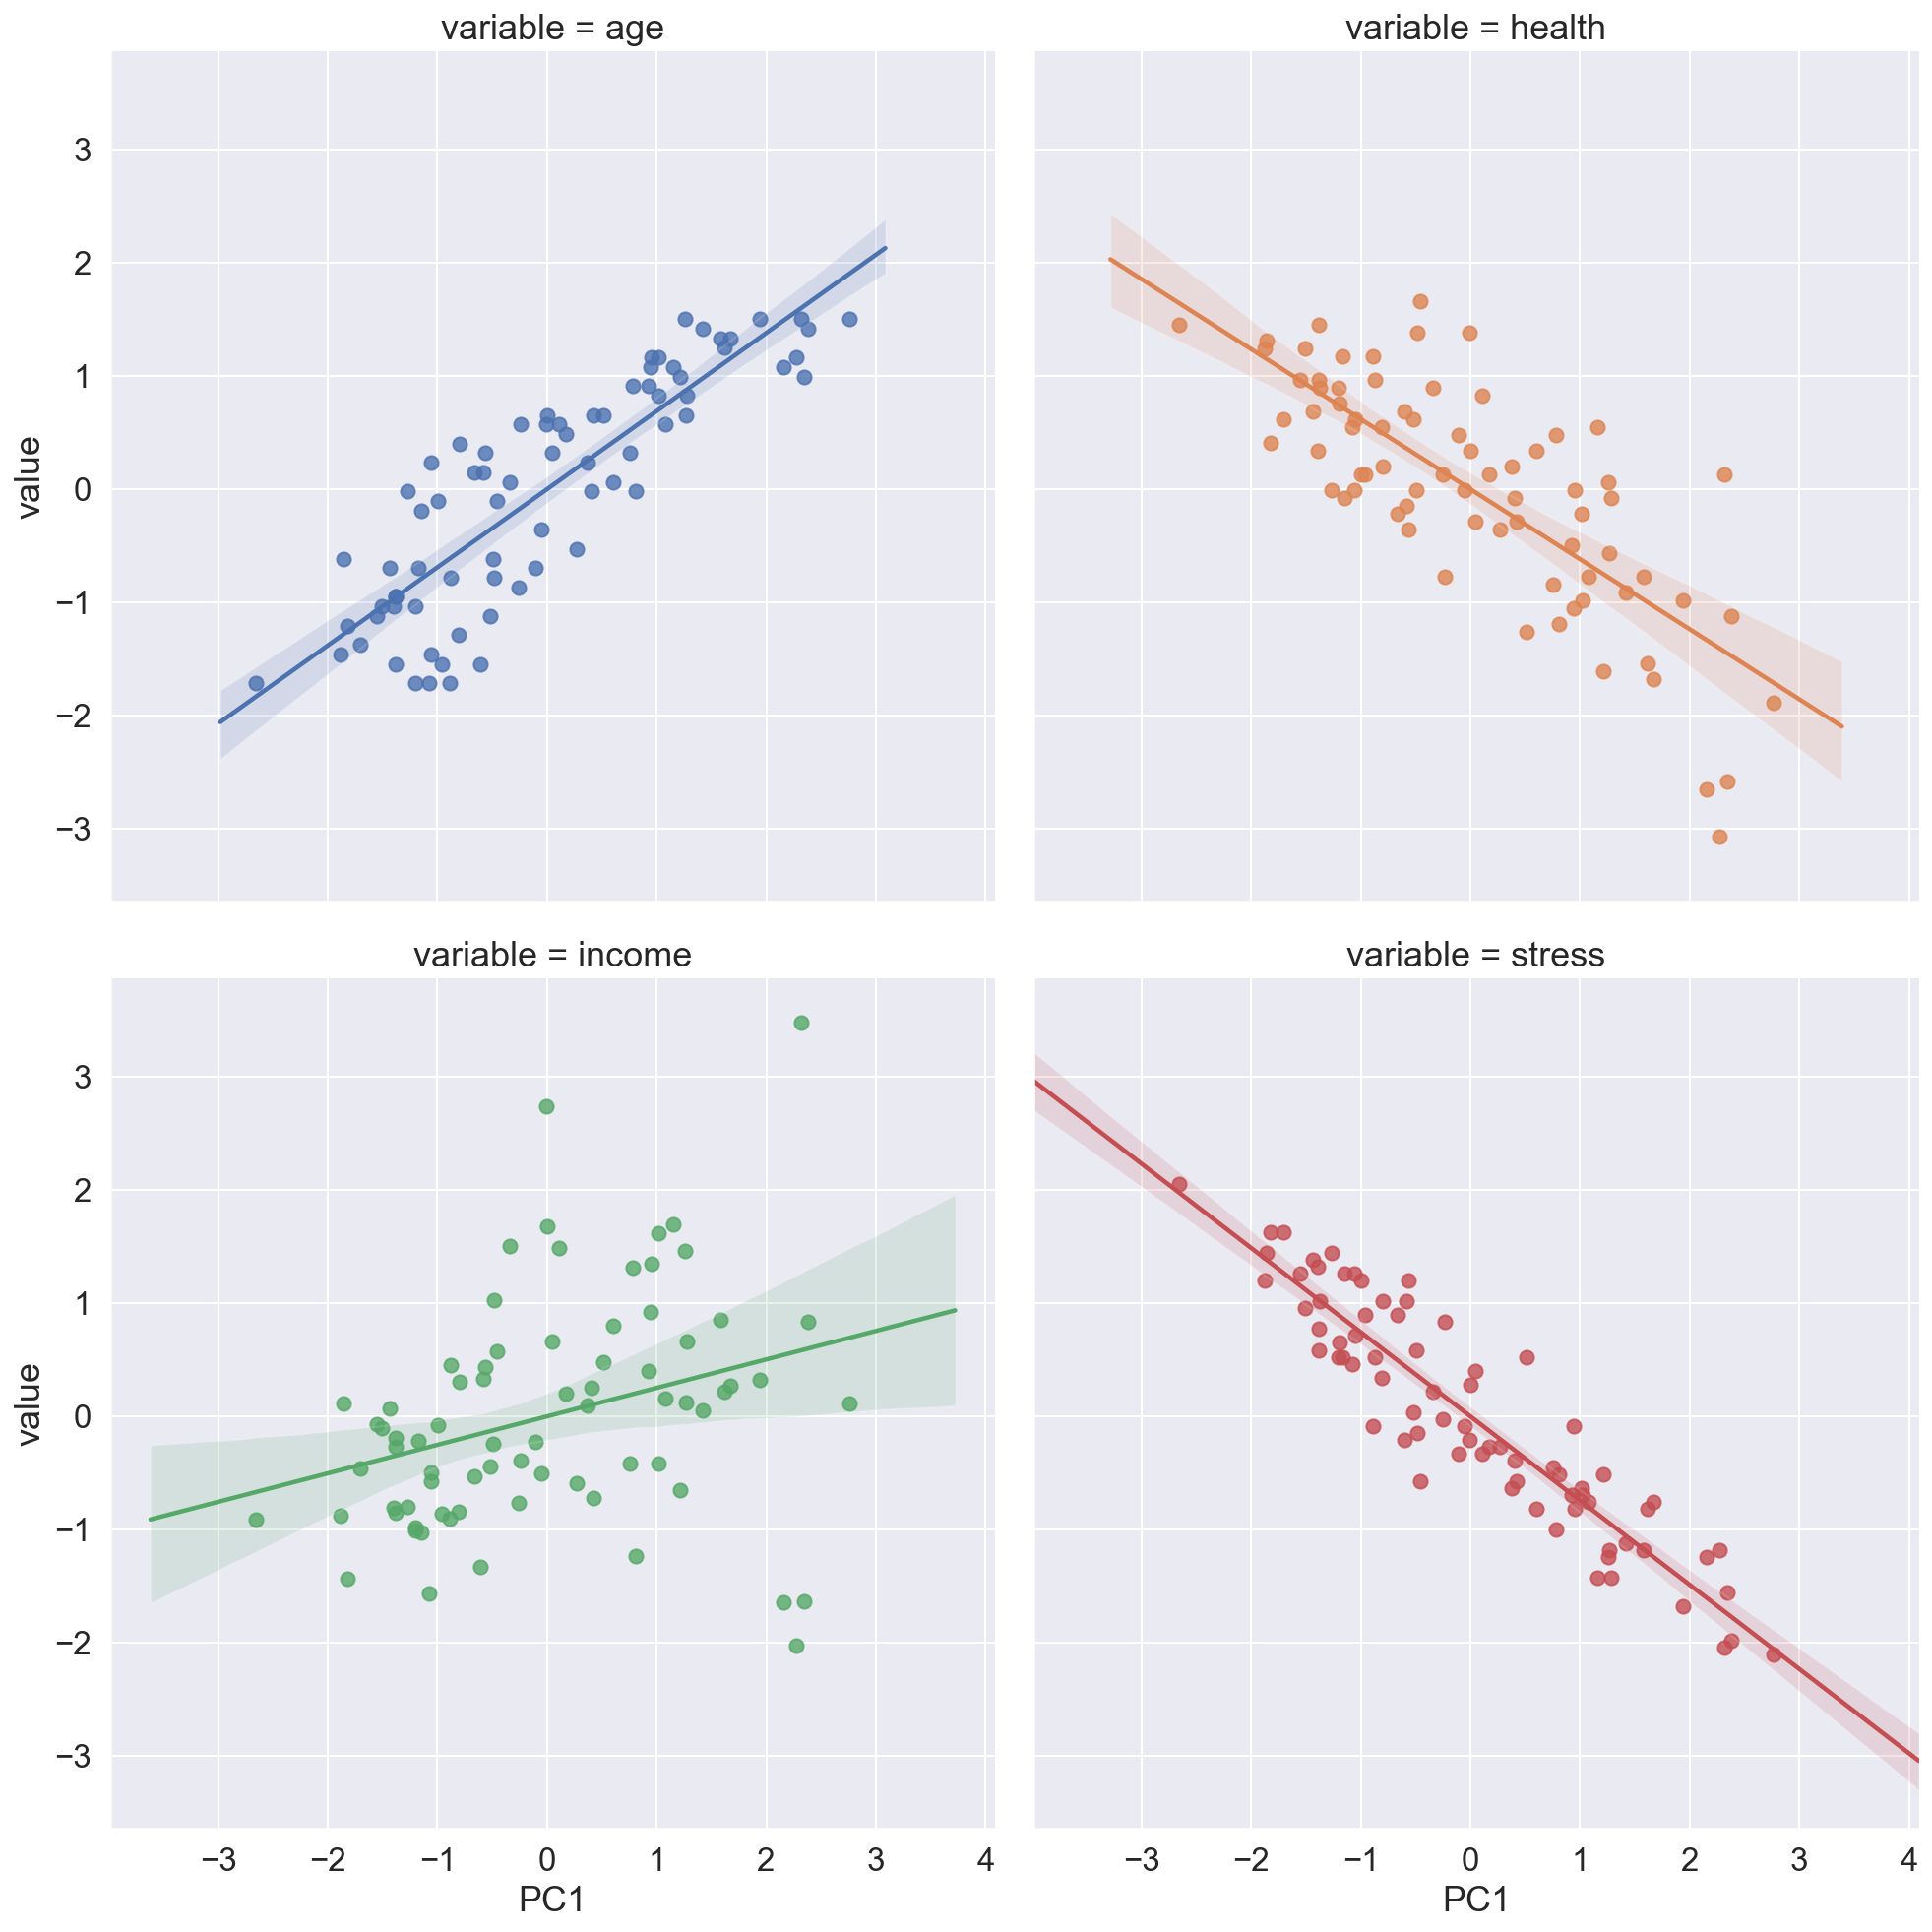

In [38]:
lmplot = sns.lmplot(x="PC1", y="value", col="variable", hue="variable",
                    data=demo_pcs, col_wrap=2, size=7, scatter_kws={'s': 50})

### 12. Use lmplot to do the same for PC2

Notice how PC2 captures the variance of income, which was not captured well by PC1. This makes sense, as the variance each principal component captures has to be orthogonal to the other components.

---

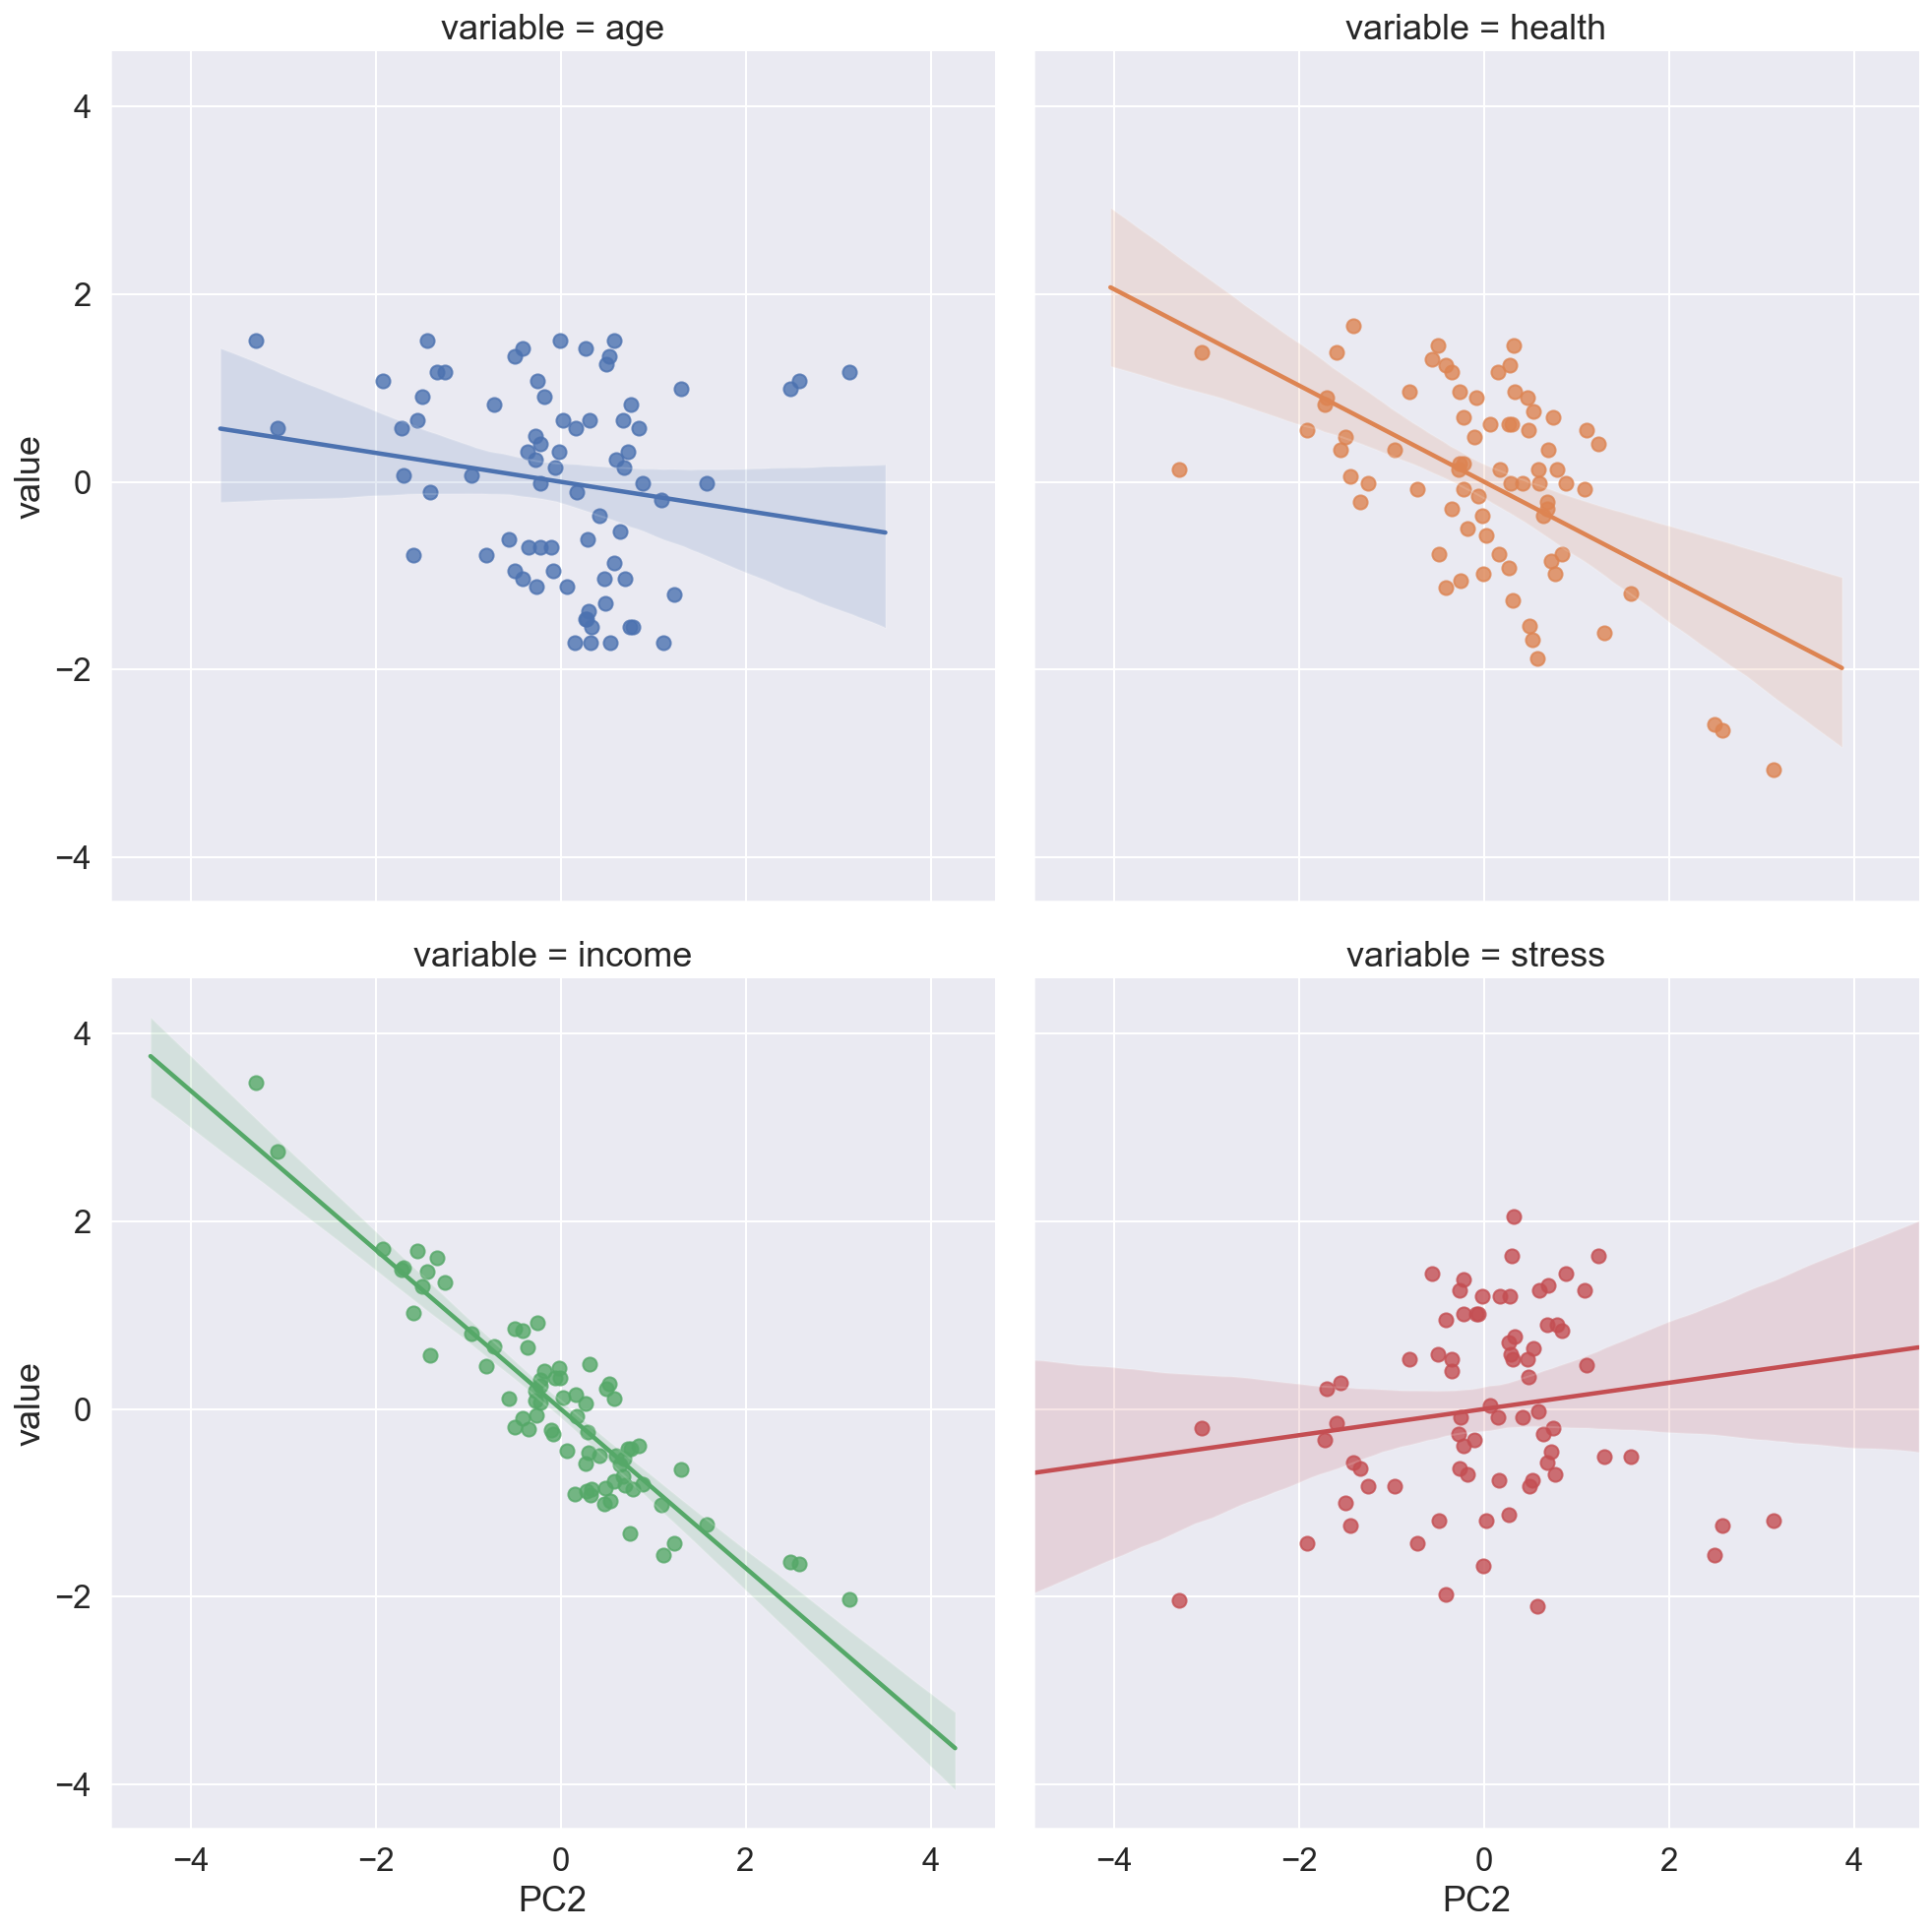

In [39]:
pc2 = sns.lmplot(x="PC2", y="value", col="variable", hue="variable",
                 data=demo_pcs, col_wrap=2, size=7, scatter_kws={'s': 50})

<a id="sklearn"></a>
## PCA with sklearn

Principle components are easily obtained with [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

In [40]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(demo_noage)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [41]:
print("Number of principal components:\t", pca.n_components_)
print("Explained variance:\t\t", np.round(pca.explained_variance_, 3))
print("Explained variance ratio:\t", np.round(pca.explained_variance_ratio_, 3))

Number of principal components:	 3
Explained variance:		 [1.577 1.189 0.274]
Explained variance ratio:	 [0.519 0.391 0.09 ]


In [42]:
eigen_values

array([0.2736, 1.5775, 1.1894])

Project on the principal components:

In [43]:
print(pca.fit_transform(demo_noage)[:5, :])

[[-0.8883 -0.1511 -1.174 ]
 [-0.1052  0.1029 -0.6019]
 [-1.3816  0.5001 -0.5673]
 [-0.8735  0.8031 -0.0173]
 [ 1.5768  0.4943  0.0878]]


Compare to the manual calculation:

In [44]:
demo_pcs.iloc[:, :2].head()

,PC1,PC2
0,-0.888292,0.151081
1,-0.105246,-0.102894
2,-1.381570,-0.500060
3,-0.873514,-0.803147
4,1.576772,-0.494324


> **Note:** The sign of the eigenvectors may depend on your specific implementation, so consistent discrepancies of signs along a whole column can be expected.

Transform back:

In [45]:
print(pca.inverse_transform(pca.fit_transform(demo_noage))[:5, :])

[[ 1.171  -0.9009 -0.0848]
 [ 0.4762 -0.221  -0.3293]
 [ 1.4489 -0.1896  0.5876]
 [ 0.9626  0.4524  0.5265]
 [-0.7745  0.8568 -1.1851]]


Compare to the original form:

In [46]:
demo_noage.head()

,health,income,stress
0,1.170996,-0.900920,-0.084764
1,0.476180,-0.220986,-0.329274
2,1.448922,-0.189621,0.587640
3,0.962551,0.452385,0.526513
4,-0.774488,0.856779,-1.185061


### Is linear regression on principal components alway better than any subset of features?

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [48]:
model = LinearRegression()

#### Fit on the three original variables

In [49]:
model.fit(demo_noage, demo.age)
print(model.score(demo_noage, demo.age))
print(cross_val_score(model, demo_noage, demo.age, cv=5).mean())

0.8781543210731468
0.855597445128141


In [50]:
model.coef_

array([-8.5685,  7.0949, -1.4385])

#### Fit on the three principal components

In [51]:
model.fit(pca.fit_transform(demo_noage), demo.age)
print(model.score(pca.fit_transform(demo_noage), demo.age))
print(cross_val_score(model, pca.fit_transform(demo_noage), demo.age, cv=5).mean())

0.8781543210731468
0.8555974451281412


In [52]:
model.coef_

array([8.1584, 1.8189, 7.4806])

#### Fit on the first two principal components

In [53]:
model.fit(pca.fit_transform(demo_noage)[:, :2], demo.age)
print(model.score(pca.fit_transform(demo_noage)[:, :2], demo.age))
print(cross_val_score(model, pca.fit_transform(
    demo_noage)[:, :2], demo.age, cv=5).mean())

0.769933508136257
0.7224046717460783


#### Fit on the first principal component

In [54]:
model.fit(pca.fit_transform(demo_noage)[:, :1], demo.age)
print(model.score(pca.fit_transform(demo_noage)[:, :1], demo.age))
print(cross_val_score(model, pca.fit_transform(
    demo_noage)[:, :1], demo.age, cv=5).mean())

0.7421201587873774
0.6991520916716726


#### Fit on the three original variables

In [55]:
model.fit(demo_noage[['income', 'stress', 'health']], demo.age)
print(model.score(demo_noage[['income', 'stress', 'health']], demo.age))
print(cross_val_score(
    model, demo_noage[['income', 'stress', 'health']], demo.age, cv=5).mean())

0.8781543210731468
0.855597445128141


#### Fit on the two of the original variables (three different possibilities)

In [56]:
model.fit(demo_noage[['income', 'stress']], demo.age)
print(model.score(demo_noage[['income', 'stress']], demo.age))
print(cross_val_score(
    model, demo_noage[['income', 'stress']], demo.age, cv=5).mean())

0.5830766506472971
0.4879591926894217


In [57]:
model.fit(demo_noage[['income', 'health']], demo.age)
print(model.score(demo_noage[['income', 'health']], demo.age))
print(cross_val_score(
    model, demo_noage[['income', 'health']], demo.age, cv=5).mean())

0.8705650042018791
0.8568906292182659


In [58]:
model.fit(demo_noage[['stress', 'health']], demo.age)
print(model.score(demo_noage[['stress', 'health']], demo.age))
print(cross_val_score(
    model, demo_noage[['stress', 'health']], demo.age, cv=5).mean())

0.6317160888595944
0.570727477801767


#### Fit on one of the original variables (three possibilities)

In [59]:
model.fit(demo_noage[['income']], demo.age)
print(model.score(demo_noage[['income']], demo.age))
print(cross_val_score(model, demo_noage[['income']], demo.age, cv=5).mean())

0.253602918292823
0.201050817946195


In [60]:
model.fit(demo_noage[['stress']], demo.age)
print(model.score(demo_noage[['stress']], demo.age))
print(cross_val_score(model, demo_noage[['stress']], demo.age, cv=5).mean())

0.5088646428962887
0.41973924315682093


In [61]:
model.fit(demo_noage[['health']], demo.age)
print(model.score(demo_noage[['health']], demo.age))
print(cross_val_score(model, demo_noage[['health']], demo.age, cv=5).mean())

0.45446771614173287
0.39567109580484255


#### Comparison of correlations between `age` and original variables/principal components

In [62]:
demo.corr()['age']

age       1.000000
health   -0.674142
income    0.503590
stress   -0.713347
Name: age, dtype: float64

In [63]:
df_pca = pd.DataFrame(pca.fit_transform(demo_noage))
df_pca['age'] = demo.age

In [64]:
df_pca.corr()['age']

0      0.861464
1      0.166773
2      0.328969
age    1.000000
Name: age, dtype: float64

<a id="conclusions"></a>
## Conclusions

- PCA is a useful technique for dimensionality reduction
- Use a particular coordinate transformation to transform the original features to new features
- The new features are completely uncorrelated
- The new features can be ranked by their contribution to the total variance
- Dimensionality reduction is obtained by discarding features with minor contributions to the total variance

<a id="more-reading"></a>
### Additional Resources

---

[PCA 4 dummies](https://georgemdallas.wordpress.com/2013/10/30/principal-component-analysis-4-dummies-eigenvectors-eigenvalues-and-dimension-reduction/)

[Stackoverflow making sense of PCA](http://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues)

[PCA and spectral theorem](http://stats.stackexchange.com/questions/217995/what-is-an-intuitive-explanation-for-how-pca-turns-from-a-geometric-problem-wit)

[PCA in 3 steps: eigendecomposition and SVD](http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html#pca-vs-lda)

[Tutorial on PCA](http://arxiv.org/pdf/1404.1100.pdf)

[PCA math and examples](http://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch18.pdf)